# CREMI3D Dataset Exploration

This notebook provides exploratory data analysis (EDA) of the CREMI3D dataset
for connectomics neuron and synapse segmentation.

## Contents
1. Load and inspect volume data (samples A, B, C)
2. Visualize EM slices and labels
3. Label distribution analysis (neurons, clefts, mitochondria)
4. Resolution and anisotropy

In [ ]:
import sys
sys.path.insert(0, '..')

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from pathlib import Path

from neurons.preprocessors import HDF5Preprocessor

# ---------- Matplotlib defaults: LaTeX font, tab20, aspect=equal ----------
matplotlib.rcParams.update({
    'text.usetex': False,
    'font.family': 'serif',
    'font.serif': ['Computer Modern Roman', 'DejaVu Serif'],
    'mathtext.fontset': 'cm',
    'font.size': 12,
    'axes.titlesize': 13,
    'axes.labelsize': 12,
})

CMAP_LABELS = plt.cm.tab20
hdf5 = HDF5Preprocessor()

%matplotlib inline

## 1. Load Volume Data

CREMI provides three samples (A, B, C). Each HDF5 file contains:
- `volumes/raw` -- EM image volume
- `volumes/labels/neuron_ids` -- neuron instance segmentation
- `volumes/labels/clefts` -- synaptic cleft annotations (optional)

Set `DATA_ROOT` to the directory containing your CREMI HDF5 files.

In [2]:
DATA_ROOT = Path('../data/cremi3d')

SAMPLES = ['A', 'B', 'C']

# Possible naming conventions
NAME_PATTERNS = [
    'sample_{s}_20160501.hdf',
    'sample_{s}+_20160601.hdf',
    'sample_{s}_padded_20160501.hdf',
    'sample_{s}.h5',
    'sample_{s}.hdf5',
    'sample_{s}.hdf',
]

# HDF5 key candidates for each data type
KEY_RAW    = ['volumes/raw', 'raw']
KEY_NEURON = ['volumes/labels/neuron_ids', 'neuron_ids']
KEY_CLEFT  = ['volumes/labels/clefts', 'clefts']

volumes = {}
neuron_ids = {}
clefts = {}

def _try_load(path, keys):
    """Try loading from the first matching HDF5 key."""
    for key in keys:
        try:
            return hdf5.load(str(path), key=key)
        except (KeyError, ValueError):
            continue
    return None

for s in SAMPLES:
    h5_path = None
    for pattern in NAME_PATTERNS:
        candidate = DATA_ROOT / pattern.format(s=s)
        if candidate.exists():
            h5_path = candidate
            break

    if h5_path is None:
        print(f'Sample {s}: not found')
        continue

    print(f'Sample {s}: {h5_path.name}')

    raw = _try_load(h5_path, KEY_RAW)
    if raw is not None:
        volumes[s] = raw

    nids = _try_load(h5_path, KEY_NEURON)
    if nids is not None:
        neuron_ids[s] = nids

    clfts = _try_load(h5_path, KEY_CLEFT)
    if clfts is not None:
        clefts[s] = clfts

    if s in volumes:
        v = volumes[s]
        print(f'  raw       : {v.shape}  dtype={v.dtype}  range=[{v.min()}, {v.max()}]')
    if s in neuron_ids:
        n = neuron_ids[s]
        print(f'  neuron_ids: {n.shape}  dtype={n.dtype}  unique={len(np.unique(n))}')
    if s in clefts:
        c = clefts[s]
        valid = c[c < np.iinfo(np.uint64).max]
        print(f'  clefts    : {c.shape}  dtype={c.dtype}  unique={len(np.unique(valid))}')
    print()

Sample A: sample_A_20160501.hdf
  raw       : (125, 1250, 1250)  dtype=uint8  range=[0, 255]
  neuron_ids: (125, 1250, 1250)  dtype=uint64  unique=37366
  clefts    : (125, 1250, 1250)  dtype=uint64  unique=123

Sample B: sample_B_20160501.hdf
  raw       : (125, 1250, 1250)  dtype=uint8  range=[0, 253]
  neuron_ids: (125, 1250, 1250)  dtype=uint64  unique=1309
  clefts    : (125, 1250, 1250)  dtype=uint64  unique=131

Sample C: sample_C_20160501.hdf
  raw       : (125, 1250, 1250)  dtype=uint8  range=[0, 255]
  neuron_ids: (125, 1250, 1250)  dtype=uint64  unique=1978
  clefts    : (125, 1250, 1250)  dtype=uint64  unique=165



## 2. Visualize EM Slices and Labels

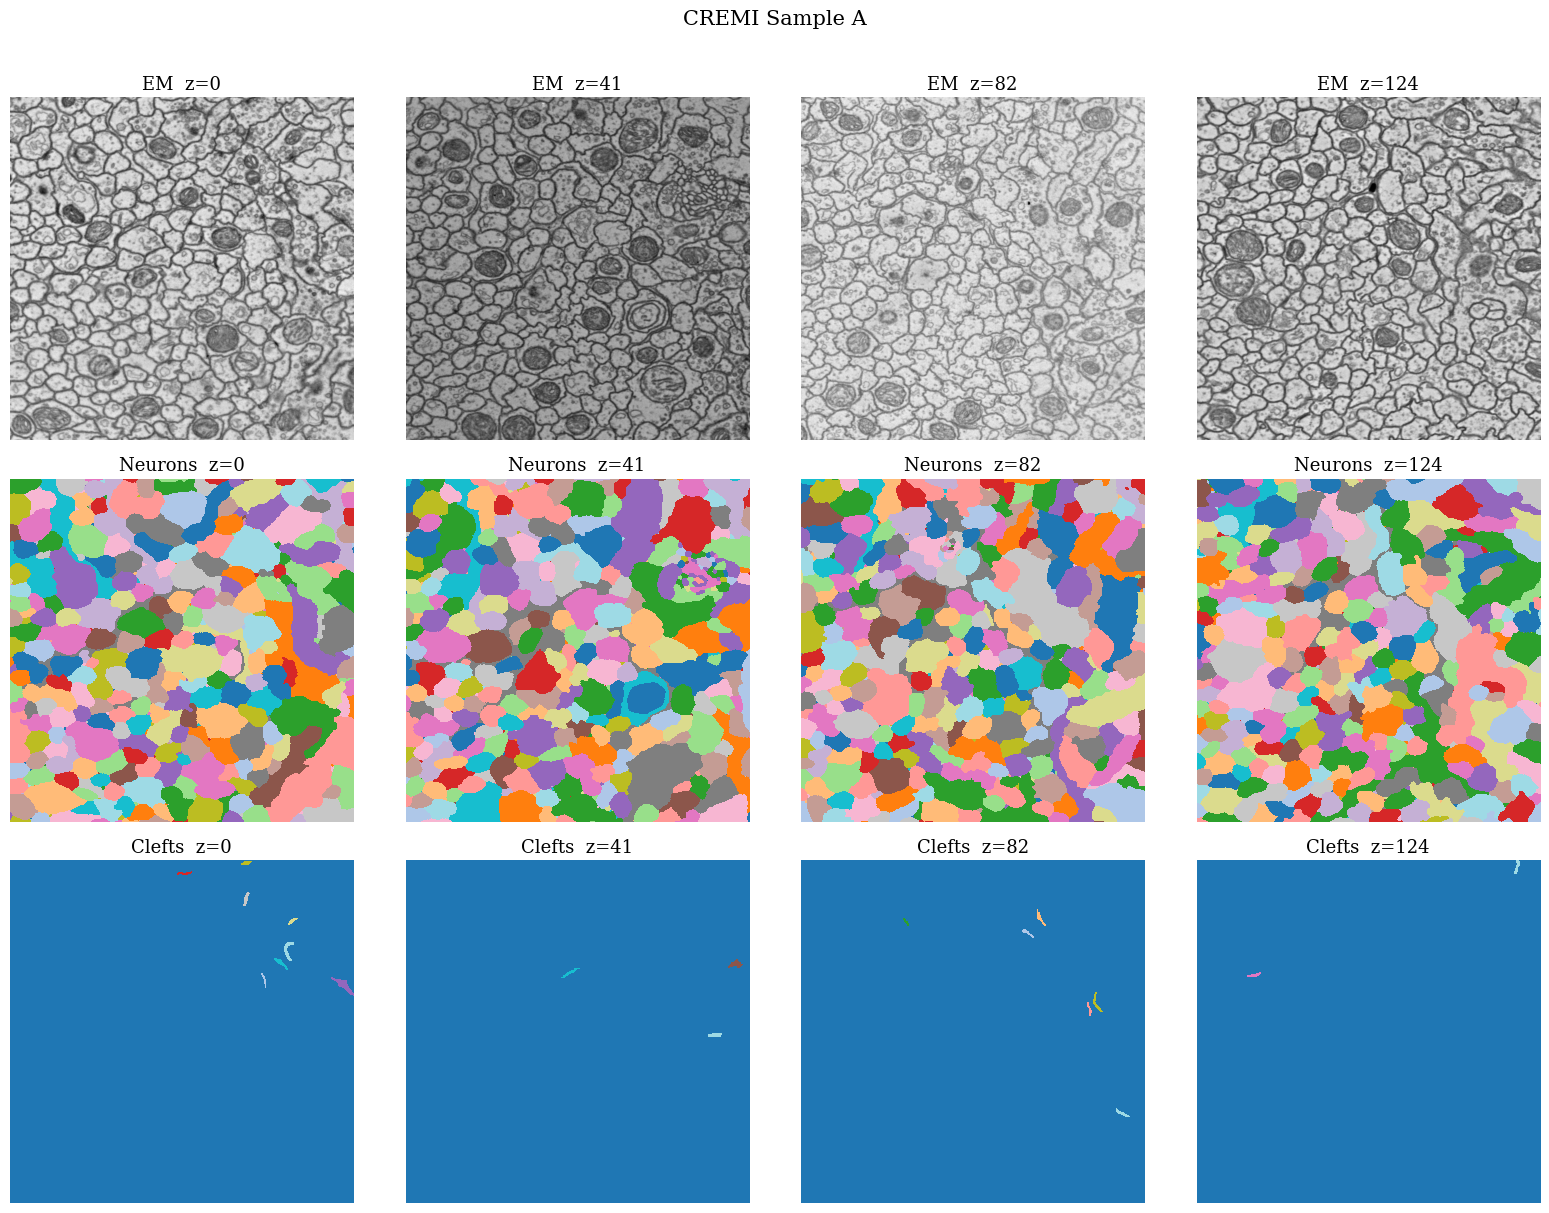

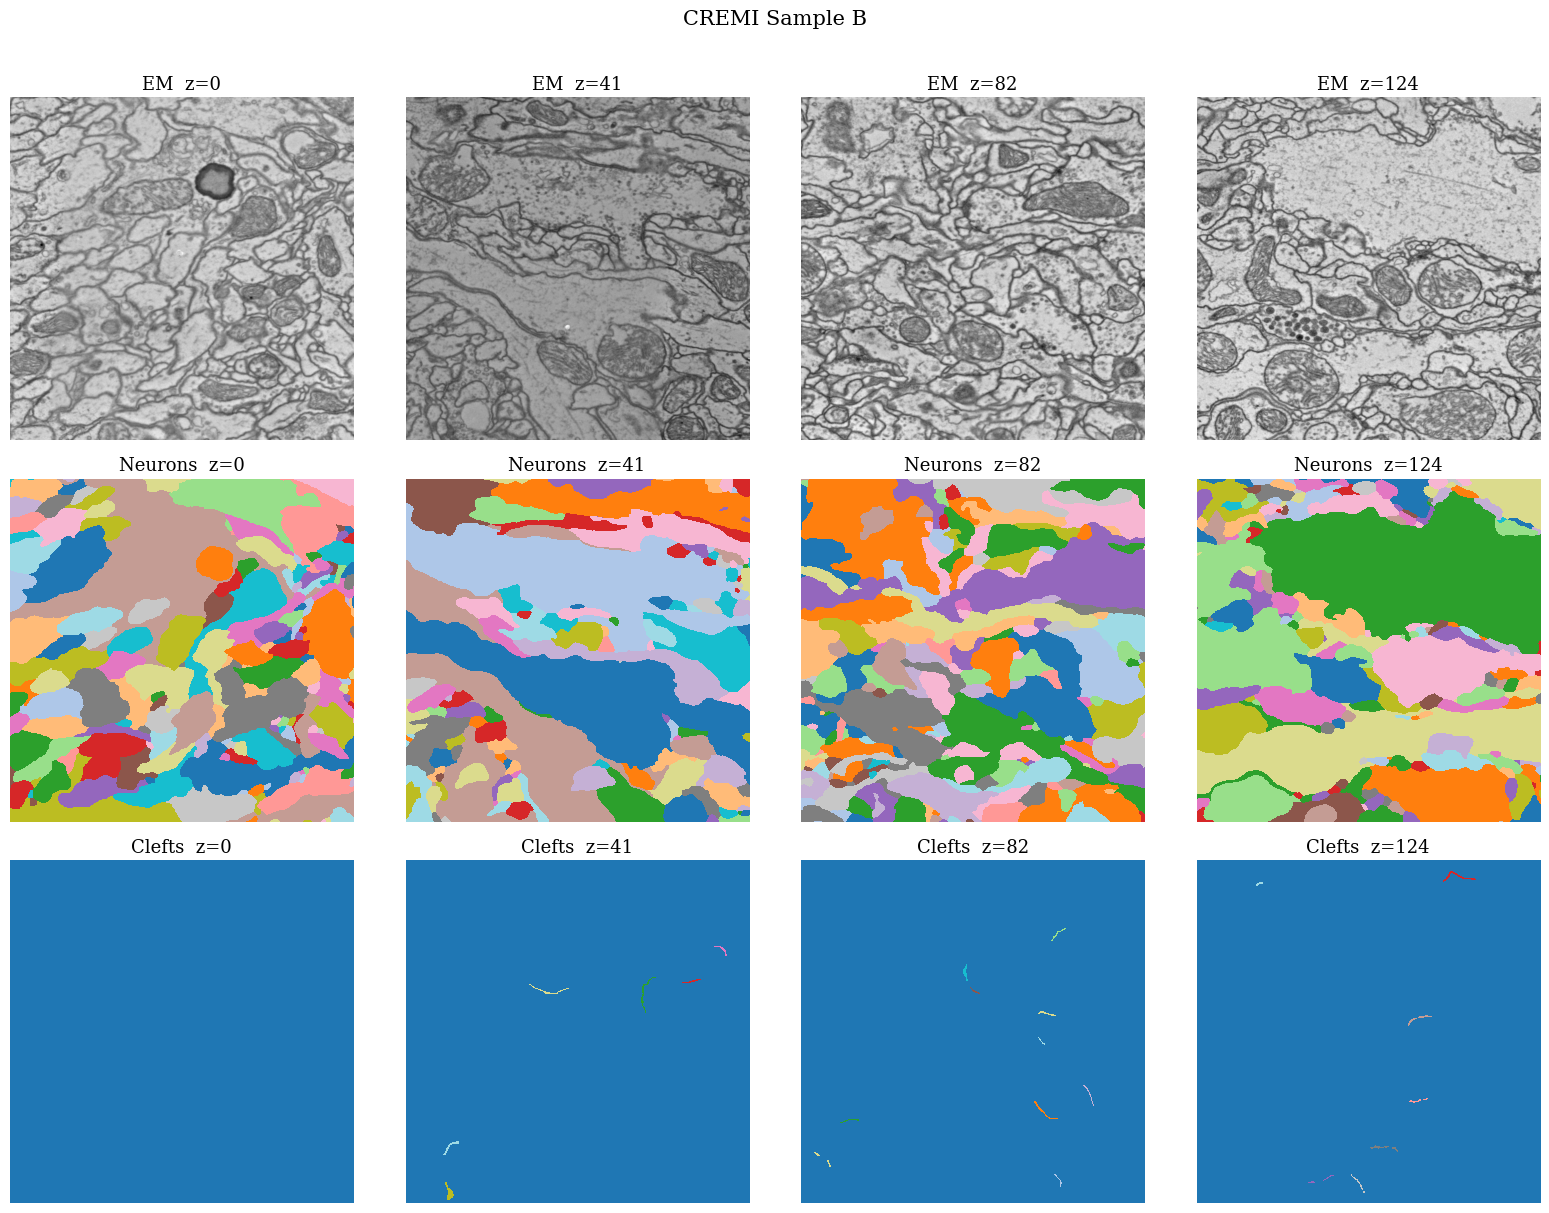

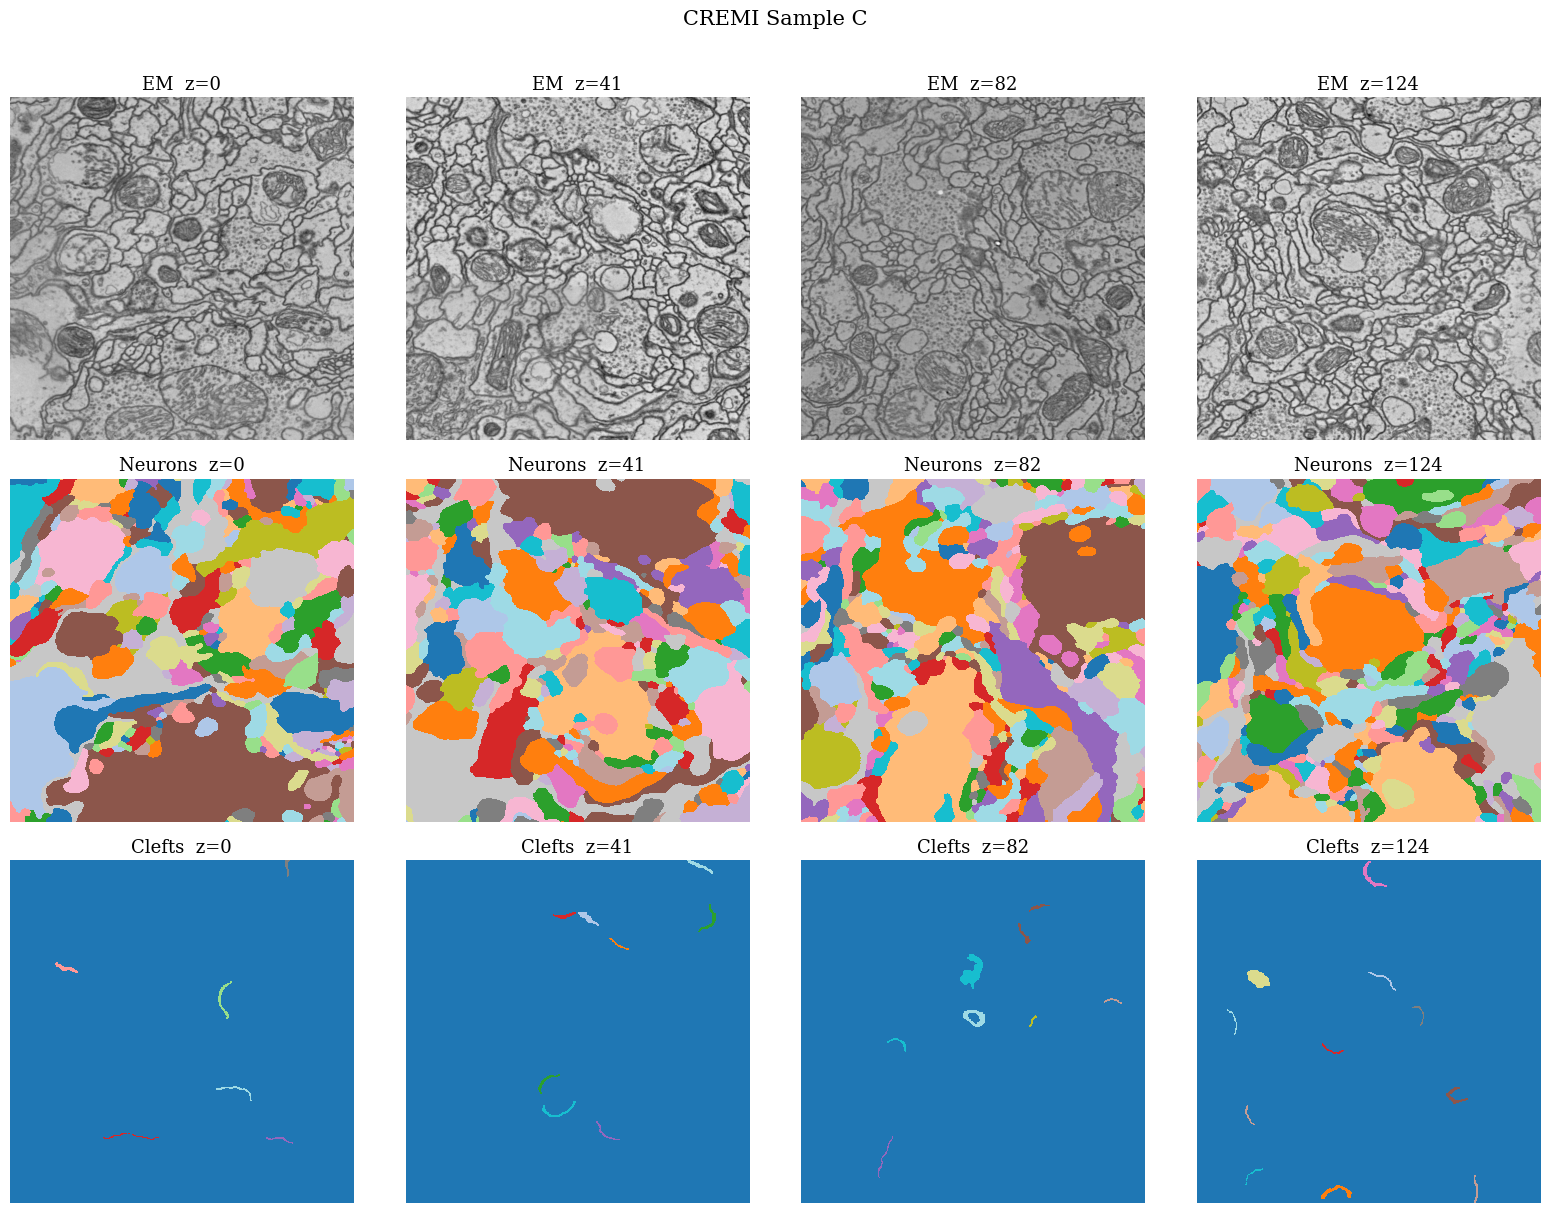

In [3]:
for s in SAMPLES:
    if s not in volumes:
        continue

    vol = volumes[s]
    has_neurons = s in neuron_ids
    has_clefts = s in clefts
    n_rows = 1 + int(has_neurons) + int(has_clefts)

    slice_indices = np.linspace(0, vol.shape[0] - 1, 4, dtype=int)

    fig, axes = plt.subplots(n_rows, 4, figsize=(16, 4 * n_rows))
    if n_rows == 1:
        axes = axes[np.newaxis, :]

    for i, idx in enumerate(slice_indices):
        row = 0
        axes[row, i].imshow(vol[idx], cmap='gray', aspect='equal')
        axes[row, i].set_title(f'EM  z={idx}')
        axes[row, i].axis('off')

        if has_neurons:
            row += 1
            axes[row, i].imshow(neuron_ids[s][idx] % 20, cmap=CMAP_LABELS, interpolation='nearest', aspect='equal')
            axes[row, i].set_title(f'Neurons  z={idx}')
            axes[row, i].axis('off')

        if has_clefts:
            row += 1
            cleft_slice = clefts[s][idx].copy().astype(np.float64)
            cleft_slice[cleft_slice >= np.iinfo(np.uint64).max] = 0
            axes[row, i].imshow(cleft_slice % 20, cmap=CMAP_LABELS, interpolation='nearest', aspect='equal')
            axes[row, i].set_title(f'Clefts  z={idx}')
            axes[row, i].axis('off')

    fig.suptitle(f'CREMI Sample {s}', fontsize=15, y=1.01)
    fig.tight_layout()
    plt.show()

## 3. Label Distribution

--- Sample A ---
  Background voxels :            0 (0.0%)
  Foreground voxels :  195,312,500 (100.0%)
  Neuron instances  : 37366
  Cleft instances   : 123
  Cleft voxels      :      440,599


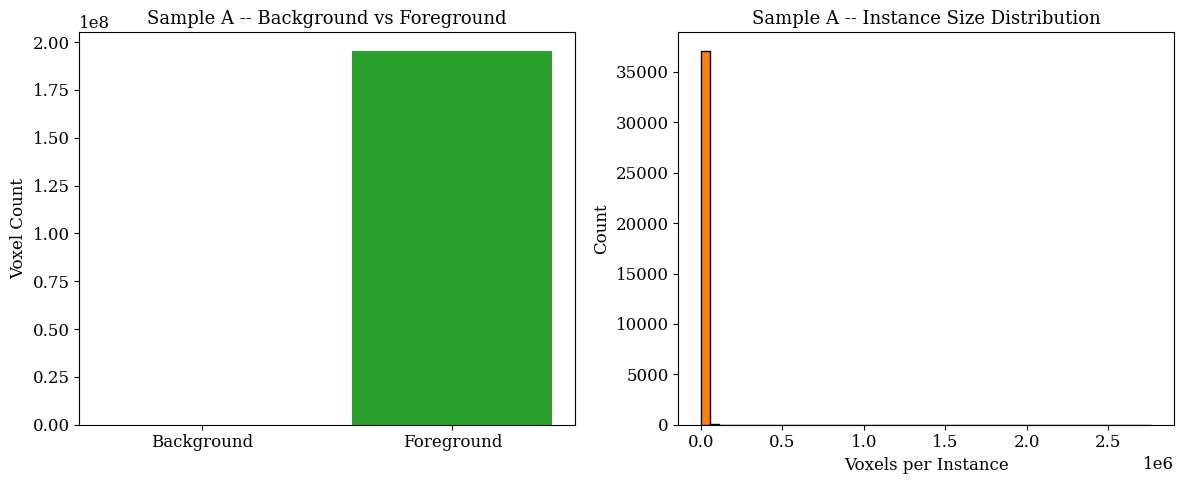


--- Sample B ---
  Background voxels :            0 (0.0%)
  Foreground voxels :  195,312,500 (100.0%)
  Neuron instances  : 1309
  Cleft instances   : 131
  Cleft voxels      :      461,056


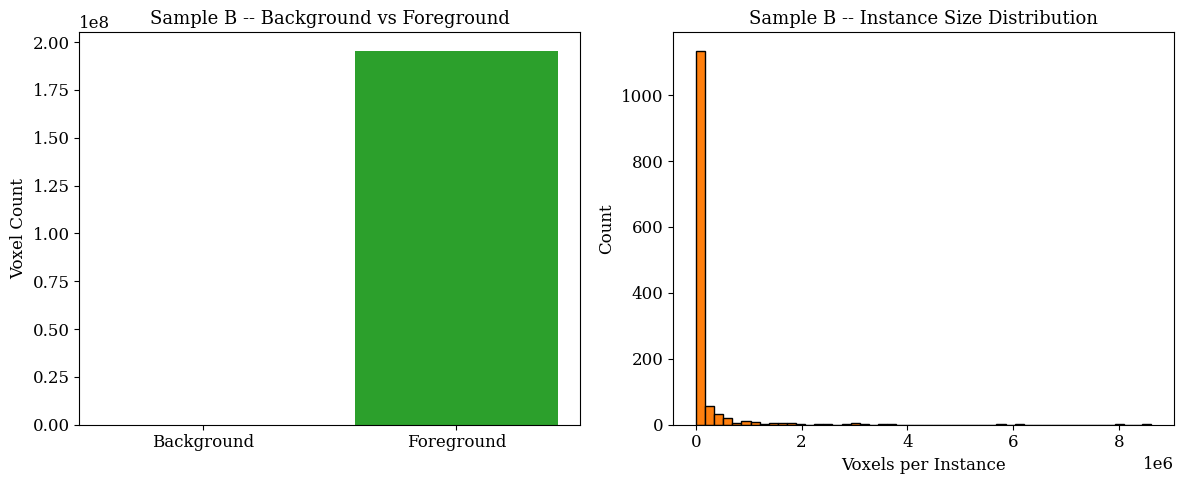


--- Sample C ---
  Background voxels :            0 (0.0%)
  Foreground voxels :  195,312,500 (100.0%)
  Neuron instances  : 1978
  Cleft instances   : 165
  Cleft voxels      :    1,402,035


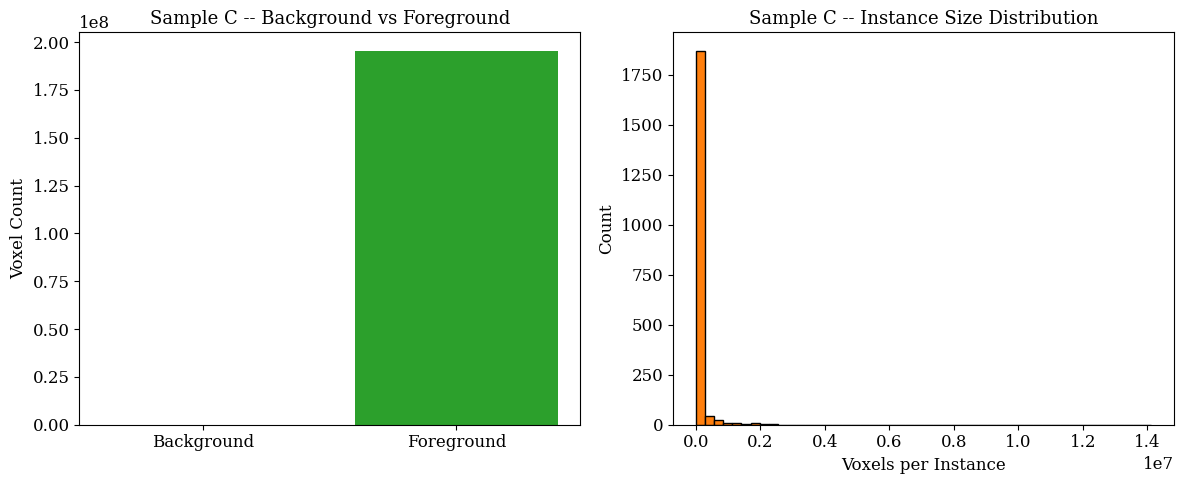

In [4]:
for s in SAMPLES:
    if s not in neuron_ids:
        continue

    nids = neuron_ids[s]
    unique_ids, counts = np.unique(nids, return_counts=True)

    bg_count = int(counts[unique_ids == 0].sum()) if 0 in unique_ids else 0
    fg_count = int(counts[unique_ids > 0].sum())
    n_instances = len(unique_ids[unique_ids > 0])

    print(f'--- Sample {s} ---')
    print(f'  Background voxels : {bg_count:>12,} ({100 * bg_count / nids.size:.1f}%)')
    print(f'  Foreground voxels : {fg_count:>12,} ({100 * fg_count / nids.size:.1f}%)')
    print(f'  Neuron instances  : {n_instances}')

    if s in clefts:
        c = clefts[s]
        valid_clefts = c[(c > 0) & (c < np.iinfo(np.uint64).max)]
        print(f'  Cleft instances   : {len(np.unique(valid_clefts))}')
        print(f'  Cleft voxels      : {len(valid_clefts):>12,}')

    fg_counts = counts[unique_ids > 0]

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    colors_bar = [CMAP_LABELS(0), CMAP_LABELS(4)]
    axes[0].bar(['Background', 'Foreground'], [bg_count, fg_count], color=colors_bar)
    axes[0].set_title(f'Sample {s} -- Background vs Foreground')
    axes[0].set_ylabel('Voxel Count')
    axes[0].set_aspect('auto')

    axes[1].hist(fg_counts, bins=50, edgecolor='black', color=CMAP_LABELS(2))
    axes[1].set_title(f'Sample {s} -- Instance Size Distribution')
    axes[1].set_xlabel('Voxels per Instance')
    axes[1].set_ylabel('Count')
    axes[1].set_aspect('auto')

    fig.tight_layout()
    plt.show()
    print()

## 4. Resolution and Anisotropy

CREMI has anisotropic resolution: 4 x 4 x 40 nm (XY vs Z).

In [5]:
resolution = {'x': 4.0, 'y': 4.0, 'z': 40.0}  # nanometers
anisotropy = resolution['z'] / resolution['x']

print(f'Resolution: {resolution}')
print(f'Anisotropy factor (Z/XY): {anisotropy:.1f}x')
print(f'\nImplication: Z-axis has {anisotropy:.0f}x lower resolution than XY.')
print('Consider using anisotropic augmentations and patch sizes.')

Resolution: {'x': 4.0, 'y': 4.0, 'z': 40.0}
Anisotropy factor (Z/XY): 10.0x

Implication: Z-axis has 10x lower resolution than XY.
Consider using anisotropic augmentations and patch sizes.
